In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import math

RESHAPED = 1
NB_CLASSES = 1
DROPOUT = 0.3
N_HIDDEN = 512
BATCH_SIZE = 15
EPOCHS = 10
VERBOSE = 1
VALIDATION_SPLIT = 0.2
CHECKPOINT_NAME = './checkpoints/model03_checkpoint01'

TRANSFORMATION = 3

DATA_URL = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
LABEL_COLUMN = 'total_deaths'
    
file_path = tf.keras.utils.get_file("owid-covid-data.csv", DATA_URL)

SELECT_COLUMNS = ['iso_code', 'total_cases', 'total_deaths']
DEFAULTS = ['', 0.0, 0.0]

def apply_transformation(original_value):
    return (original_value/100000)**TRANSFORMATION

def get_dataset(file_path, **kwargs):
    dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=1, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True, 
      shuffle=True,
      **kwargs)
    return dataset

covid_dataset = get_dataset(file_path, select_columns=SELECT_COLUMNS, column_defaults = DEFAULTS)
            
def convert_to_train_test_data(dataset, test_percent = 0.05):
    total_deaths = []
    transformed_total_cases = []
    total_cases = []
    for independent, dependent in dataset.as_numpy_iterator():
        if independent.get('iso_code')[0] == b'USA':
            total_deaths.append(dependent[0])
            transformed_total_cases.append([apply_transformation(independent.get('total_cases')[0])])
            total_cases.append([independent.get('total_cases')[0]])
    testRecordCount = int(round(test_percent*len(total_deaths)))
    return transformed_total_cases[testRecordCount:], total_cases[testRecordCount:], total_deaths[testRecordCount:], transformed_total_cases[:testRecordCount], total_cases[:testRecordCount], total_deaths[:testRecordCount]
    
x_train_transformed, x_train, y_train, x_test_transformed, x_test, y_test = convert_to_train_test_data(covid_dataset, test_percent=0.05)


features = ['total_cases']

def create_model(hidden_layers, input_shape, dropout, output_classes):
    opt = keras.optimizers.RMSprop(learning_rate=0.001)

    model = tf.keras.models.Sequential()
    model.add(keras.layers.Dense(hidden_layers, input_shape=(input_shape,), name='input_dense_layer',activation='relu'))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(hidden_layers, name='hidden_dense_layer',activation='relu'))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(output_classes, name='output_dense_layer'))
    
    model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
    
    return model

Train on 86 samples, validate on 22 samples
Epoch 1/10
86/86 [==============================] - 0s 6ms/sample - loss: 133796024.7907 - accuracy: 0.4884 - val_loss: 29651517.9981 - val_accuracy: 0.0000e+00
Epoch 2/10
86/86 [==============================] - 0s 498us/sample - loss: 128266385.2558 - accuracy: 0.0233 - val_loss: 28422561.0364 - val_accuracy: 0.0000e+00
Epoch 3/10
86/86 [==============================] - 0s 539us/sample - loss: 122926813.5814 - accuracy: 0.0116 - val_loss: 27259143.6014 - val_accuracy: 0.0000e+00
Epoch 4/10
86/86 [==============================] - 0s 554us/sample - loss: 115482372.0000 - accuracy: 0.0116 - val_loss: 25660048.5244 - val_accuracy: 0.0000e+00
Epoch 5/10
86/86 [==============================] - 0s 647us/sample - loss: 108830886.4244 - accuracy: 0.0116 - val_loss: 23910593.3916 - val_accuracy: 0.0000e+00
Epoch 6/10
86/86 [==============================] - 0s 652us/sample - loss: 100180314.1017 - accuracy: 0.0116 - val_loss: 22180453.9635 - val_a

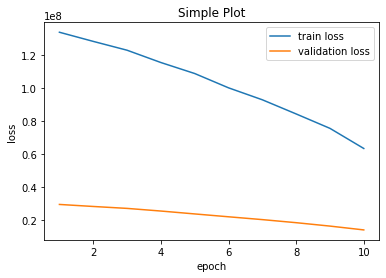

In [2]:
model = create_model(N_HIDDEN, RESHAPED, DROPOUT, NB_CLASSES)

history = model.fit(np.array(x_train_transformed), np.array(y_train), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

model.save_weights(CHECKPOINT_NAME)

test_loss, test_acc = model.evaluate(np.array(x_test_transformed), np.array(y_test))
print()
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(validation_loss)+1)

fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(epochs, train_loss, label='train loss')
ax.plot(epochs, validation_loss, label='validation loss')
ax.set_xlabel('epoch')  # Add an x-label to the axes.
ax.set_ylabel('loss')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend() 


In [3]:
model = create_model(N_HIDDEN, RESHAPED, DROPOUT, NB_CLASSES)

test_loss, test_acc = model.evaluate(np.array(x_test_transformed), np.array(y_test))
print()
print('Test loss:', test_loss)

model.load_weights(CHECKPOINT_NAME)

test_loss, test_acc = model.evaluate(np.array(x_test_transformed), np.array(y_test))
print()
print('Test loss:', test_loss)



6/6 [==============================] - 0s 10ms/sample - loss: 276220128.0000 - accuracy: 0.5000

Test loss: 276220128.0
6/6 [==============================] - 0s 515us/sample - loss: 100659528.0000 - accuracy: 0.0000e+00

Test loss: 100659528.0


Train on 86 samples, validate on 22 samples
Epoch 1/10
86/86 [==============================] - 0s 6ms/sample - loss: 55690393.0950 - accuracy: 0.0116 - val_loss: 12346723.3521 - val_accuracy: 0.0000e+00
Epoch 2/10
86/86 [==============================] - 0s 575us/sample - loss: 45625624.0497 - accuracy: 0.0116 - val_loss: 10140008.5367 - val_accuracy: 0.0000e+00
Epoch 3/10
86/86 [==============================] - 0s 630us/sample - loss: 34870591.0116 - accuracy: 0.0116 - val_loss: 8100567.6189 - val_accuracy: 0.0000e+00
Epoch 4/10
86/86 [==============================] - 0s 605us/sample - loss: 28685666.2558 - accuracy: 0.0116 - val_loss: 6114658.7739 - val_accuracy: 0.0000e+00
Epoch 5/10
86/86 [==============================] - 0s 621us/sample - loss: 19110228.1512 - accuracy: 0.0116 - val_loss: 4437704.4471 - val_accuracy: 0.0000e+00
Epoch 6/10
86/86 [==============================] - 0s 631us/sample - loss: 15425621.6512 - accuracy: 0.0116 - val_loss: 3005806.7493 - val_accuracy: 0

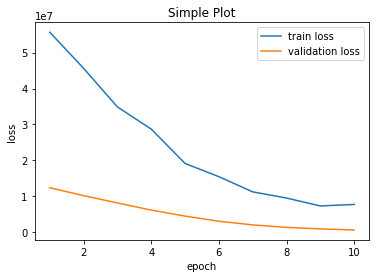

In [4]:
model = create_model(N_HIDDEN, RESHAPED, DROPOUT, NB_CLASSES)

model.load_weights(CHECKPOINT_NAME)

history = model.fit(np.array(x_train_transformed), np.array(y_train), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

test_loss, test_acc = model.evaluate(np.array(x_test_transformed), np.array(y_test))
print()
print('Test loss:', test_loss)

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(validation_loss)+1)

fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(epochs, train_loss, label='train loss')
ax.plot(epochs, validation_loss, label='validation loss')
ax.set_xlabel('epoch')  # Add an x-label to the axes.
ax.set_ylabel('loss')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend() 


[[99381.12]]


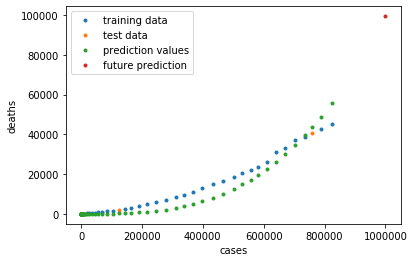

In [5]:
CASE_COUNT = 1000000
FUTURE_CASES = [CASE_COUNT]
FUTURE_CASES_TANSFORMED = [apply_transformation(CASE_COUNT)]
FUTURE_PREDICTION = []

PREDICTED_CASES = []
PREDICTED_DEATHS = []

pred_traning_deaths = model.predict(np.array(x_train_transformed))

count = 0
for deaths in pred_traning_deaths:
    PREDICTED_CASES.append(x_train[count])
    PREDICTED_DEATHS.append(deaths)
    count += 1

pred_validation_deaths = model.predict(np.array(x_test_transformed))

count = 0
for deaths in pred_validation_deaths:
    PREDICTED_CASES.append(x_test[count])
    PREDICTED_DEATHS.append(deaths)
    count += 1

pred_deaths = model.predict(FUTURE_CASES_TANSFORMED)

for deaths in pred_deaths:
    FUTURE_PREDICTION.append(deaths)
    
print(pred_deaths)
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(x_train, y_train, label='training data', linewidth=0, marker='.')
ax.plot(x_test, y_test, label='test data', linewidth=0, marker='.')
ax.plot(PREDICTED_CASES, PREDICTED_DEATHS, label='prediction values', linewidth=0, marker='.')
ax.plot(FUTURE_CASES, FUTURE_PREDICTION, label='future prediction', linewidth=0, marker='.')
ax.set_xlabel('cases')  # Add an x-label to the axes.
ax.set_ylabel('deaths')  # Add a y-label to the axes.
ax.legend() 